In [1]:
!pip install tensorflow tensorflow_probability


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 45.4 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 39.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 6.3 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.5 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 951.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 46.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 48.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.4 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting r

This Bayesian neural network model aims to solve a simple regression problem. The primary difference between a Bayesian neural network and a standard neural network is that the Bayesian version incorporates uncertainty in the model's weights. This is achieved by treating the weights and biases as random variables with probability distributions instead of single-point estimates.

Here's a detailed explanation of the code and the model's components:

Data generation: We generate synthetic data for the regression problem by creating an input x with values uniformly distributed between -1 and 1. The corresponding output y is created as a linear function of x (y = 2x) with added Gaussian noise (mean = 0, std = 0.2).

Model creation: The Bayesian neural network is built using the Keras functional API. The input layer takes a single value (shape = (1,)). The model then adds a hidden dense layer with 32 units and ReLU activation. We use the DenseReparameterization layer from TensorFlow Probability, which allows us to define the weights and biases with probability distributions. For both the kernel (weights) and bias, we use a normal prior and a mean-field variational family for the posterior approximation. The output layer has a single unit with a linear activation function, also using the DenseReparameterization layer for Bayesian treatment of the weights and biases.

Negative log-likelihood loss: We define a custom loss function called nll (negative log-likelihood). For each prediction y_pred, we assume a Gaussian distribution of errors with a fixed standard deviation (0.2) and calculate the log probability of the true value y_true under this distribution. We then minimize the negative of this log probability.

Model compilation and training: We compile the model using the Adam optimizer with a learning rate of 0.01 and our custom nll loss function. The model is trained for 1000 epochs with the synthetic data we generated earlier.

Prediction and visualization: To visualize the model's predictions and uncertainty, we make multiple predictions (100 in this case) for each input value in a test set (equally spaced between -1 and 1). We then calculate the mean and standard deviation of these predictions, which represent the predicted mean and uncertainty, respectively. Finally, we plot the data points, the predicted mean, and the uncertainty (1 standard deviation) as a shaded area around the mean.

This Bayesian neural network model provides a way to quantify the uncertainty in its predictions. The uncertainty can be useful in various applications, such as decision-making under uncertainty, active learning, and identifying areas where the model lacks confidence.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras import layers
from tensorflow.keras.models import Model

tfd = tfp.distributions
tfpl = tfp.layers


2023-04-24 20:01:28.313666: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 20:01:30.884205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 20:01:30.891894: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 20:01:32.356588: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Next, we'll generate some synthetic data for the regression problem:

# Generate synthetic data



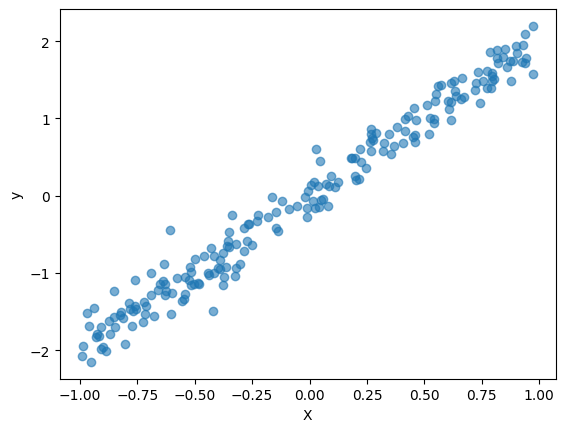

In [3]:
np.random.seed(42)

def generate_data(n_samples=200):
    x = np.random.uniform(-1, 1, size=n_samples)
    y = 2 * x + np.random.normal(0, 0.2, size=n_samples)
    return x[:, np.newaxis], y

X, y = generate_data()
plt.scatter(X, y, alpha=0.6)
plt.xlabel('X')
plt.ylabel('y')
plt.show()

Now, let's create the Bayesian neural network model:

In [4]:
def build_bayesian_nn():
    # Input layer
    inputs = layers.Input(shape=(1,))
    
    # Dense layer with variational posterior weights and biases
    dense = tfpl.DenseReparameterization(
        units=32,
        activation='relu',
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(),
        name='dense'
    )(inputs)
    
    # Output layer with variational posterior weights and biases
    output = tfpl.DenseReparameterization(
        units=1,
        kernel_prior_fn=tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(),
        bias_prior_fn=tfpl.default_multivariate_normal_fn,
        bias_posterior_fn=tfpl.default_mean_field_normal_fn(),
        name='output'
    )(dense)
    
    # Create the model
    model = Model(inputs=inputs, outputs=output)
    return model

bayesian_nn = build_bayesian_nn()
bayesian_nn.summary()


/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/codespace/.python/current/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (DenseReparameterizat  (None, 32)               128       
 ion)                                                            
                                                                 
 output (DenseReparameteriza  (None, 1)                66        
 tion)                                                           
                                                                 
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


Define the negative log-likelihood loss and compile the model:

In [7]:
def nll(y_true, y_pred):
    # Assuming Gaussian distribution of errors with fixed std (0.2)
    distribution = tfd.Normal(loc=y_pred, scale=0.2)
    return -tf.reduce_mean(distribution.log_prob(y_true))


bayesian_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=nll)


Train the Bayesian neural network:

In [12]:
history = bayesian_nn.fit(X, y, epochs=1000, verbose=1)


Epoch 1/1000
7/7 [==============================] - 0s 2ms/step - loss: 181.5440
Epoch 2/1000
7/7 [==============================] - 0s 2ms/step - loss: 176.0731
Epoch 3/1000
7/7 [==============================] - 0s 2ms/step - loss: 170.0777
Epoch 4/1000
7/7 [==============================] - 0s 2ms/step - loss: 163.5395
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 157.2775
Epoch 6/1000
7/7 [==============================] - 0s 2ms/step - loss: 150.7521
Epoch 7/1000
7/7 [==============================] - 0s 2ms/step - loss: 145.6199
Epoch 8/1000
7/7 [==============================] - 0s 2ms/step - loss: 139.8564
Epoch 9/1000
7/7 [==============================] - 0s 2ms/step - loss: 135.9301
Epoch 10/1000
7/7 [==============================] - 0s 2ms/step - loss: 131.7553
Epoch 11/1000
7/7 [==============================] - 0s 2ms/step - loss: 123.4956
Epoch 12/1000
7/7 [==============================] - 0s 2ms/step - loss: 118.6896
Epoch 13/1000
7/7 [======

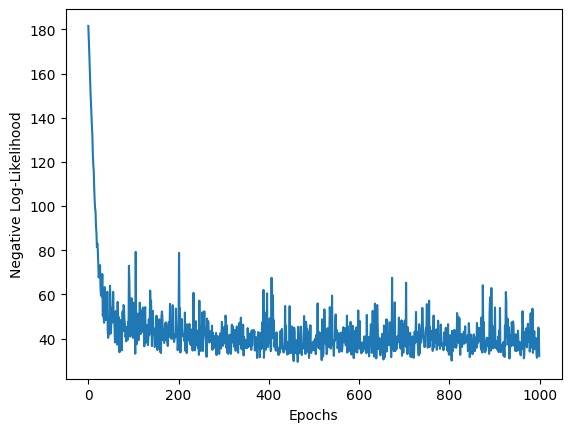

In [13]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Negative Log-Likelihood')
plt.show()


4/4 [==============================] - 0s 1ms/step


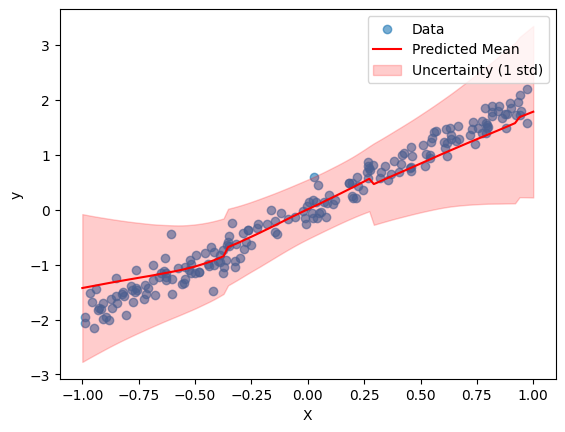

In [14]:
# Make predictions
n_predictions = 100
x_test = np.linspace(-1, 1, n_predictions)
y_preds = np.stack([bayesian_nn.predict(x_test) for _ in range(100)], axis=0)

# Calculate mean and standard deviation
y_mean = np.mean(y_preds, axis=0).squeeze()
y_std = np.std(y_preds, axis=0).squeeze()

# Visualize the results
plt.scatter(X, y, alpha=0.6, label='Data')
plt.plot(x_test, y_mean, color='red', label='Predicted Mean')
plt.fill_between(x_test, y_mean - y_std, y_mean + y_std, color='red', alpha=0.2, label='Uncertainty (1 std)')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()